# DeepTICA
In this notebook we compute two Collective Variables (CVs) of alanine dipeptide using the DeepTICA method introduced in [this paper](https://doi.org/10.1073/pnas.2113533118) by L. Bonati and al. A dependency of this notebook is the package [mlcvs](https://github.com/luigibonati/mlcvs).

In [29]:
#Standard imports
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import random_split
#MD-related imports
from stateinterpreter.utils.io import load_dataframe
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from mlcvs.tica import DeepTICA_CV

### Load data

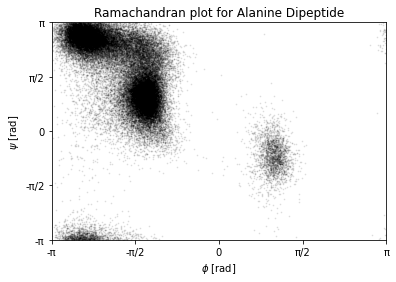

In [23]:
colvar = load_dataframe('alanine/COLVAR') # Load collective variable file
ax = colvar.plot.scatter('phi','psi',s=0.5, alpha=0.1, c='k')
#Plot Styling
ax.margins(0)
ax.set_xlabel(r"$\phi$ [rad]")
ax.set_ylabel(r"$\psi$ [rad]")
ax.set_title("Ramachandran plot for Alanine Dipeptide")
ax.set_xticks(np.arange(-np.pi, np.pi+np.pi/2, step=(np.pi/2)))
ax.set_xticklabels(['-π','-π/2','0','π/2','π'])
ax.set_yticks(np.arange(-np.pi, np.pi+np.pi/2, step=(np.pi/2)))
ax.set_yticklabels(['-π','-π/2','0','π/2','π'])
plt.show()

### Compute DeepTICA

In [26]:
X = colvar.filter(regex='d_').values # Extract only the distances (prefix 'd_') from the COLVAR file
n_input = X.shape[1]

# Calculate inverse temperature
temp = 300.       
kb = 0.008314
beta = 1./(kb*temp)

t = colvar['time'].values # Extract simulation times
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweight = beta*bias

In [28]:
lag_time = 1.0 #Setting lag time
# Create dataset for DeepTICA training.
dataset = create_time_lagged_dataset(
    X,
    t=t,
    lag_time=lag_time,
    logweights=logweight
)
#Train/validation split
n_train  = int( 0.8 * len(dataset) )
n_valid  = len(dataset) - n_train
train_data, valid_data = random_split(dataset,[n_train,n_valid]) 

# Dataloaders 
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

Time-lagged pairs:	 89868
Training data:		 71894
Validation data:	 17974


In [31]:
#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 2

lrate             = 1e-3
l2_reg            = 0.

num_epochs        = 1000
earlystop         = True
es_patience       = 10
es_consecutive    = False

log_every         = 10
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(nodes)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)

# REGULARIZATION
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,min_delta=0.,consecutive=es_consecutive, save_best_model=True, log=False)

# TRAIN
model.fit(
    train_loader,valid_loader,
    standardize_inputs=True,
    standardize_outputs=True,
    loss_type=loss_type,
    n_eig=n_eig,
    nepochs=num_epochs,
    info=False, log_every=log_every
)
model.to('cpu')

Epoch Train Loss  Valid Loss  Eigenvalues             
10    -0.260      -0.267      0.503  -0.002 
20    -0.292      -0.294      0.538  -0.001 
30    -0.321      -0.320      0.563  0.022  
40    -0.618      -0.614      0.629  0.350  
50    -1.094      -1.083      0.891  0.529  
60    -1.191      -1.176      0.943  0.544  
70    -1.230      -1.211      0.957  0.558  
80    -1.257      -1.233      0.963  0.572  
90    -1.277      -1.250      0.967  0.582  
100   -1.292      -1.261      0.971  0.589  
110   -1.304      -1.268      0.974  0.594  
120   -1.313      -1.274      0.977  0.599  
130   -1.322      -1.279      0.979  0.602  
140   -1.329      -1.283      0.981  0.605  
150   -1.335      -1.287      0.982  0.608  
160   -1.341      -1.290      0.983  0.611  
170   -1.346      -1.292      0.985  0.613  
180   -1.350      -1.294      0.986  0.615  
190   -1.354      -1.295      0.987  0.617  
200   -1.358      -1.296      0.987  0.619  
210   -1.362      -1.296      0.988  0.620  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

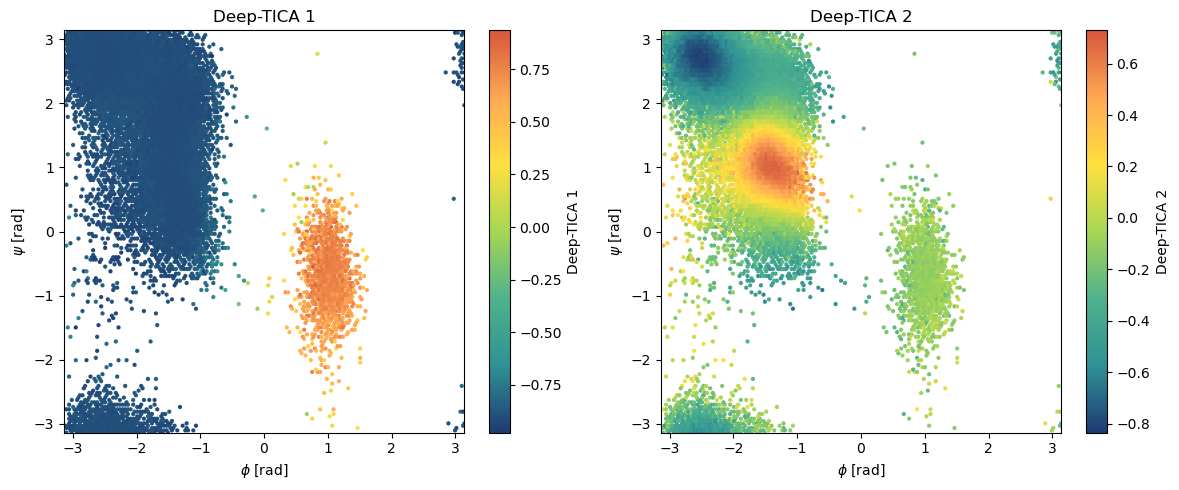

In [32]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

x = colvar['phi'].values
y = colvar['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.margins(0)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

In [33]:
# Evaluate tica collective variables, store in colvar dataframe and save it.
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
for i in range(s.shape[1]):
    colvar[f'DeepTICA {i+1}'] = s[:,i]
#colvar.to_csv('alanine/COLVAR_DeepTICA')